NOTE: If some rows are commented out, it means that it is done for data protection reasons not to display unique id's of the posts. In the process of the work, these lines were used. Also some descriptive lines where id-s were displayed were eliminated from this file for security reasons but were a part of the work.

# Importing necessary packages

In [1]:
import pandas as pd
import numpy as np
import copy
import json
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import masi_distance, jaccard_distance

# Data Preparation

## Initial investigation and preparation

In [2]:
#READING IN DATA FROM FILES
GAD0_0 = pd.read_json('Reddit_GAD0_0.json', lines = True)
GAD0_1 = pd.read_json('Reddit_GAD0_1.json', lines = True)
GAD1_0 = pd.read_json('Reddit_GAD1_0.json', lines = True)
GAD1_1 = pd.read_json('Reddit_GAD1_1.json', lines = True)
GAD2_0 = pd.read_json('Reddit_GAD2_0.json', lines = True)
GAD2_1 = pd.read_json('Reddit_GAD2_1.json', lines = True)
GAD3_0 = pd.read_json('Reddit_GAD3_0.json', lines = True)
GAD3_1 = pd.read_json('Reddit_GAD3_1.json', lines = True)
GAD4_0 = pd.read_json('Reddit_GAD4_0.json', lines = True)
GAD4_1 = pd.read_json('Reddit_GAD4_1.json', lines = True)

***Annotator 1 dataset***

In [3]:
GAD0 = GAD0_0.append([GAD1_0, GAD2_0, GAD3_0, GAD4_0])

In [4]:
#PREPARE ANNOTATOR 1 DATASET WITH NONE TYPES IN LABEL, NOTE COLUMN

#SEPARATE CONTENT COLUMN INTO TWO COLUMNS: UNIQUE_ID AND TEXT
GAD0['unique_id'] = GAD0.content.str.split('\n', expand = True)[0]
GAD0['text'] = GAD0.content.str.split('\n',1, expand = True)[1]

GAD0['label_1'] = GAD0['annotation'].map(lambda x: x if x == None else x['labels'])
GAD0['note_1'] = GAD0['annotation'].map(lambda x: x if x == None else x['note'])

#DROP UNNECESSARY COLUMNS
GAD0 = GAD0.drop(['content', 'annotation', 'extras', 'metadata'], axis = 1)

***Annotator 2 dataset***

In [5]:
GAD1 = GAD0_1.append([GAD1_1, GAD2_1, GAD3_1, GAD4_1])
#EXAMPLE PRINT
#GAD1.head()

In [6]:
#PREPARE ANNOTATOR 2 DATASET WITH NONE TYPES IN LABEL, NOTE COLUMN

#SEPARATE CONTENT COLUMN INTO TWO COLUMNS: UNIQUE_ID AND TEXT
GAD1['unique_id'] = GAD1.content.str.split('\n', expand = True)[0]
GAD1['text'] = GAD1.content.str.split('\n',1, expand = True)[1]

GAD1['label_2'] = GAD1['annotation'].map(lambda x: x if x == None else x['labels'])
GAD1['note_2'] = GAD1['annotation'].map(lambda x: x if x == None else x['note'])

#DROP UNNECESSARY COLUMNS
GAD1 = GAD1.drop(['content', 'annotation', 'extras', 'metadata'], axis = 1)

#HAVE A LOOK AT THE FINAL DATAFRAME
#GAD1.head()

***Merge Annotator1 and Annotator2 data into one dataframe***

In [7]:
df_both_annotators = pd.merge(GAD0, GAD1, on=['unique_id', 'text'], how='inner')
#df_both_annotators.head()

In [8]:
#SOME LABELS ARE OF NONE TYPE
#df_both_annotators[df_both_annotators['label_1'].isna()]

In [9]:
#SOME LABELS ARE OF NONE TYPE
#df_both_annotators[df_both_annotators['label_2'].isna()]

In [10]:
#SOME LABELS ARE JUST '[]' -> LEAVING THESE IN THE DATASET
#df_both_annotators[df_both_annotators.astype(str)['label_1'] == '[]']

In [11]:
#SOME LABELS ARE JUST '[]' -> LEAVING THESE IN THE DATASET
#df_both_annotators[df_both_annotators.astype(str)['label_1'] == '[]']
#df_both_annotators[df_both_annotators.astype(str)['label_2'] == '[]']

In [12]:
#SORTING LABELS IN ALPHABETICAL ORDERING -> NEEDED FOR INVESTIGATING HOW MUCH AND WHICH UNIQUE LABELS I HAVE (GROUPING ROWS TOGETHER)
df_both_annotators['label_1'] = df_both_annotators['label_1'].map(lambda x: x if x == None else sorted(x)) 
df_both_annotators['label_2'] = df_both_annotators['label_2'].map(lambda x: x if x == None else sorted(x)) 

In [13]:
#I replace [, 'Not Distorted'] value just with ['Not Distorted'] in one row
df_both_annotators.at[308, 'label_2'] = ['Not Distorted']

In [14]:
#df_both_annotators.head()

In [15]:
#DISTRIBUTION OF LABELS FOR ANNOTATOR 1
df_count_label_1 = pd.DataFrame(df_both_annotators.label_1.value_counts()).rename_axis('labels_1').reset_index().rename(columns = {'label_1': 'count_1'})
not_distorted_count_1 = df_count_label_1.iloc[0]['count_1']
distorted_count_df_1 = df_count_label_1.drop([0])
distorted_count_1 = distorted_count_df_1['count_1'].sum()

not_distorted_perc_1 = round(not_distorted_count_1/(not_distorted_count_1+distorted_count_1)*100,0)
distorted_perc_1 = round(distorted_count_1/(not_distorted_count_1+distorted_count_1)*100,0)

print(df_count_label_1)

print('\n')
print("There are", not_distorted_count_1, str("(" + str(not_distorted_perc_1) + "%)"), "not distorted labels and", distorted_count_1, str("(" + str(distorted_perc_1) + "%)"), "distorted labels marked by annotator 1" )

                                             labels_1  count_1
0                                     [Not Distorted]      239
1                                   [Catastrophizing]      109
2                               [Arbitrary Inference]       40
3                                          [Labeling]       23
4                                [Overgeneralization]       21
5                                   [Personalization]       18
6                             [Selective Abstraction]       15
7                          [Black and White Thinking]       13
8              [Arbitrary Inference, Catastrophizing]        2
9         [Black and White Thinking, Catastrophizing]        2
10               [Black and White Thinking, Labeling]        2
11                     [Labeling, Overgeneralization]        1
12           [Catastrophizing, Selective Abstraction]        1
13                    [Arbitrary Inference, Labeling]        1
14  [Arbitrary Inference, Catastrophizing, Labelin...  

In [16]:
for idx, element in enumerate(df_both_annotators['label_2']):
  if element == ['Not Distorted', 'Personalization']:
    print(idx, element)

#print(df_both_annotators.iloc[[358]])

#I replace ['Not Distorted', 'Personalization'] value with ['Not Distorted']
df_both_annotators.at[358, 'label_2'] = ['Not Distorted']

358 ['Not Distorted', 'Personalization']


In [17]:
#DISTRIBUTION OF LABELS FOR ANNOTATOR 2
df_count_label_2 = pd.DataFrame(df_both_annotators.label_2.value_counts()).rename_axis('labels_2').reset_index().rename(columns = {'label_2': 'count_2'})
not_distorted_count_2 = df_count_label_2.iloc[0]['count_2']
distorted_count_df_2 = df_count_label_2.drop([0])
distorted_count_2 = distorted_count_df_2['count_2'].sum()

not_distorted_perc_2 = round(not_distorted_count_2/(not_distorted_count_2+distorted_count_2)*100,0)
distorted_perc_2 = round(distorted_count_2/(not_distorted_count_2+distorted_count_2)*100,0)

print(df_count_label_2)

print('\n')
print("There are", not_distorted_count_2, str("(" + str(not_distorted_perc_2) + "%)"), "not distorted labels and", distorted_count_2, str("(" + str(distorted_perc_2) + "%)"), "distorted labels marked by annotator 2" )

                                             labels_2  count_2
0                                     [Not Distorted]      235
1                                   [Catastrophizing]       93
2                               [Arbitrary Inference]       41
3                                          [Labeling]       33
4                                   [Personalization]       28
5                                [Overgeneralization]       28
6                             [Selective Abstraction]       15
7                                                  []        3
8                          [Black and White Thinking]        3
9              [Arbitrary Inference, Catastrophizing]        2
10  [Labeling, Overgeneralization, Selective Abstr...        2
11                    [Arbitrary Inference, Labeling]        2
12  [Arbitrary Inference, Black and White Thinking...        1
13                     [Labeling, Overgeneralization]        1
14              [Catastrophizing, Overgeneralization]  

In [18]:
#Annotator_1
df_count_label_1['labels_1'] = df_count_label_1['labels_1'].apply(lambda x: ['Multiple labels'] if len(x)>1 else x)
df_count_label_1['labels_1'] = df_count_label_1['labels_1'].apply(lambda x: ','.join(map(str, x)))

In [19]:
#Annotator_2
df_count_label_2['labels_2'] = df_count_label_2['labels_2'].apply(lambda x: ['Multiple labels'] if len(x)>1 else x)
df_count_label_2['labels_2'] = df_count_label_2['labels_2'].apply(lambda x: ','.join(map(str, x)))

In [20]:
#df_count_label_1.to_excel("annotator_1.xlsx") 

In [21]:
#df_count_label_2.to_excel("annotator_2.xlsx") 

In [22]:
frequencies_1 = pd.read_excel('labelid.xlsx', sheet_name='Sheet1')
frequencies_1

,Labels,Annotator_1
0,Not Distorted,239
1,Catastrophizing,109
2,Arbitrary Inference,40
3,Labeling,23
4,Overgeneralization,21
5,Personalization,18
6,Selective Abstraction,15
7,Black and White Thinking,13
8,Multiple labels,12


In [23]:
frequencies_2 = pd.read_excel('labelid.xlsx', sheet_name='Sheet2')
frequencies_2

,Labels,Annotator_2
0,Not Distorted,235
1,Catastrophizing,93
2,Arbitrary Inference,41
3,Labeling,33
4,Overgeneralization,28
5,Personalization,28
6,Selective Abstraction,15
7,Black and White Thinking,3
8,Multiple labels,10


Word cloud

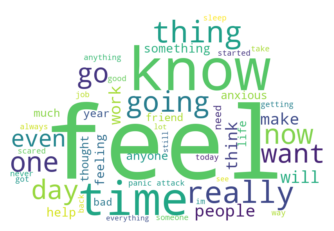

In [24]:
#source: https://towardsdatascience.com/create-word-cloud-into-any-shape-you-want-using-python-d0b88834bc32

text = " ".join(review for review in df_both_annotators.text)
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

mask = np.array(Image.open('cloud2.jpg'))
wc = WordCloud(
               mask=mask, background_color="white",
               max_words=50, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

## Cohen's Kappa

In [25]:
#TRANSFORMING ANNOTATORS' LABELS INTO LISTS AND MAKING THEM INTO BINARY FORM
labels_ann1 = list(df_both_annotators['label_1'])
labels_ann2 = list(df_both_annotators['label_2'])

labels_ann1_encoded = []
labels_ann2_encoded = []


for x in labels_ann1:
  if x is not None:
    if 'Not Distorted' in x:
        labels_ann1_encoded.append('Not Distorted')
    elif len(x) == 0:
        labels_ann1_encoded.append(None)
    else:
      labels_ann1_encoded.append('Distorted')
  else:
      labels_ann1_encoded.append(None)

for x in labels_ann2:
  if x is not None:
    if 'Not Distorted' in x:
        labels_ann2_encoded.append('Not Distorted')
    elif len(x) == 0:
        labels_ann2_encoded.append(None)
    else:
      labels_ann2_encoded.append('Distorted')
  else:
      labels_ann2_encoded.append(None)

In [26]:
#TAKE A LOOK AT THE RESULT
#print(len(labels_ann1_encoded))
#print(labels_ann1_encoded)

#print(len(labels_ann2_encoded))
#print(labels_ann2_encoded)

In [27]:
#ADD LISTS TO DATASET AND LOOK AT THE RESULT
df_both_annotators['label_1_encoded'] = pd.Series(labels_ann1_encoded)
df_both_annotators['label_2_encoded'] = pd.Series(labels_ann2_encoded)
#df_both_annotators.head()

In [28]:
#PREPARING A CROSSTAB THAT WILL BE USED FOR CONFUSION MATRIX
cross = pd.crosstab(df_both_annotators['label_1_encoded'], df_both_annotators['label_2_encoded'])

In [29]:
#HAVING A LOOK AT THE RESULT
cross 

label_2_encoded,Distorted,Not Distorted
label_1_encoded,,
Distorted,160,89
Not Distorted,86,145


In [30]:
#CHANGE SOME COLUMNS NAMES FOR BETTER READABILITY FROM HEATMAP
df_maatriks = copy.deepcopy(df_both_annotators)
df_maatriks = df_maatriks.rename(columns={"label_1_encoded":"Annotator_1", "label_2_encoded":"Annotator_2"})
agreement_matrix_binary = pd.crosstab(df_maatriks['Annotator_1'], df_maatriks['Annotator_2'])

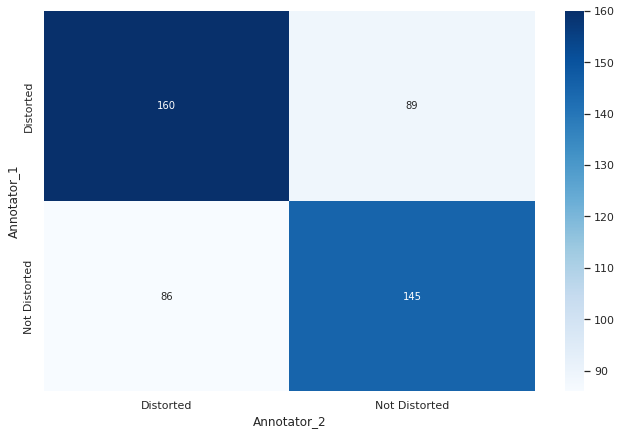

In [31]:
#CREATE CONFUSION MATRIX HEATMAP
fig, ax = plt.subplots(figsize=(11,7))
ax = sns.heatmap(agreement_matrix_binary, cmap="Blues", annot=True,fmt='g')

In [32]:
#I NEED TO FILTER OUT NULL VALUES IN ORDER TO CALCULATE COHEN'S KAPPA SCORE
cohen_df = copy.deepcopy(df_both_annotators)
cohen_df = cohen_df[cohen_df.label_1_encoded.notnull()]
cohen_df = cohen_df[cohen_df.label_2_encoded.notnull()]

#CALCULATING THE KAPPA SCORE
cohen_kappa_score(cohen_df['label_1_encoded'], cohen_df['label_2_encoded'])

#https://towardsdatascience.com/inter-rater-agreement-kappas-69cd8b91ff75 -> FAIR AGREEMENT!

0.27014909811281407

## Label binarization

Will try to binarize the dataset labels

In [33]:
#ANNOTATOR 1 
proov = copy.deepcopy(df_both_annotators)
s = proov['label_1'].explode()
hot_encoded = proov.join(pd.crosstab(s.index, s))
hot_encoded = hot_encoded.where(pd.notnull(hot_encoded), None)
#hot_encoded.head()

In [34]:
#ANNOTATOR 2
proov2 = copy.deepcopy(df_both_annotators)
s2 = proov2['label_2'].explode()
hot_encoded2 = proov2.join(pd.crosstab(s2.index, s2))
hot_encoded2 = hot_encoded2.where(pd.notnull(hot_encoded2), None)
#hot_encoded2.head()

In [35]:
#RENAME THE COLUMNS FOR BETTER UNDERSTANDING
hot_encoded2 = hot_encoded2.rename(columns={'Arbitrary Inference': 'Arbitrary Inference2', 'Black and White Thinking': 'Black and White Thinking2', 'Catastrophizing': 'Catastrophizing2', 'Labeling': 'Labeling2', 'Not Distorted': 'Not Distorted2', 'Overgeneralization': 'Overgeneralization2', 'Personalization': 'Personalization2', 'Selective Abstraction': 'Selective Abstraction2'})

In [36]:
#hot_encoded2.head()

Join Annotator 1 + Annotator 2 hot_encoded dataframes into one

In [37]:
hot_encoded_both = pd.merge(hot_encoded, hot_encoded2, on=['unique_id', 'text', 'note_1', 'note_2'], how = 'right')

hot_encoded_both.pop('label_1_y')
hot_encoded_both.pop('label_2_y')
hot_encoded_both.pop('label_2_encoded_x')
hot_encoded_both.pop('label_1_encoded_y')

hot_encoded_both = hot_encoded_both.rename(columns = {'label_1_x': 'label_1', 'label_2_x': 'label_2', 'label_1_encoded_x': 'binary label_1', 'label_2_encoded_y': 'binary label_2'})
#hot_encoded_both.head()

## Krippendorff's Alpha calculation

Krippendorff's Alpha

In [38]:
#INSTALLING LATEST VERSION OF NLTK WHERE MASI DISTANCE HAS BEEN FIXED
!pip install nltk==3.6.7 

#ENSURING I GOT THE CORRECT VERSION
import nltk
nltk.__version__

'3.6.7'

In [39]:
kripp = []
for idx, row in hot_encoded_both.iterrows():
  if row['label_1'] == None or len(row['label_1']) == 0:
    kripp.append(('1', str(idx), frozenset(['NONE'])))
  elif row['label_1'] != None:
    kripp.append(('1', str(idx), frozenset(row['label_1'])))
  if row['label_2'] == None or len(row['label_2']) == 0:
    kripp.append(('2', str(idx), frozenset(['NONE'])))
  elif row['label_2'] != None:
    kripp.append(('2', str(idx), frozenset(row['label_2'])))

In [40]:
kripp[:6]

[('1', '0', frozenset({'Catastrophizing'})),
 ('2', '0', frozenset({'Arbitrary Inference'})),
 ('1', '1', frozenset({'Catastrophizing'})),
 ('2', '1', frozenset({'Catastrophizing'})),
 ('1', '2', frozenset({'Personalization'})),
 ('2', '2', frozenset({'Labeling'}))]

In [41]:
task = AnnotationTask(kripp, distance = masi_distance)
alpha = task.alpha()
print(alpha)

0.17733769141666889


## Cohen's Kappa for each label

In [42]:
labels = ['Arbitrary Inference', 'Black and White Thinking', 	'Catastrophizing',	'Labeling',	'Overgeneralization', 'Personalization',	'Selective Abstraction']
kappas = {'Arbitrary Inference':0, 'Black and White Thinking':0, 	'Catastrophizing':0,	'Labeling':0,	'Overgeneralization':0, 'Personalization':0,	'Selective Abstraction':0}

In [43]:
tuples2 = []

for label in labels:
  # iterate over the whole dataset and fill in the tuples
  for row in kripp:
    rowList = list(row)
    if label in rowList[2]:
      rowList[2] = 1
    else:
      rowList[2] = 0
    tuples2.append(tuple(rowList))

  # initialize AnnotationTask
  task = AnnotationTask(data = tuples2)

  # get the Fleiss' Kappa value
  kappa = task.multi_kappa()
  kappas[label] = kappa
  tuples2 = []

In [44]:
kappas

{'Arbitrary Inference': -0.028393013952580638,
 'Black and White Thinking': 0.07875185735512619,
 'Catastrophizing': 0.25791505791505787,
 'Labeling': 0.28111311517650095,
 'Overgeneralization': 0.09330489755503098,
 'Personalization': 0.09024211298605853,
 'Selective Abstraction': 0.08192022928110856}

In [45]:
#SAVE DATASET AS JSON
hot_encoded_both.to_json('dataset_json_updated.json', orient="records", lines = True)

## Intersection

In [46]:
#PREPARING NEW DATASET FOR INTERSECTION AS A COPY FROM ENCODED DATASET
intersection = copy.deepcopy(hot_encoded_both)
intersection.pop('binary label_1')
intersection.pop('binary label_2')

0          Distorted
1          Distorted
2          Distorted
3          Distorted
4      Not Distorted
           ...      
491    Not Distorted
492    Not Distorted
493    Not Distorted
494    Not Distorted
495    Not Distorted
Name: binary label_2, Length: 496, dtype: object

In [47]:
#APPLY INTERSECTION LOGIC TO LABELS
label_1s = list(intersection['label_1'])
label_2s = list(intersection['label_2'])

intersection_results = []

for idx, element in enumerate(label_1s): 
  if (element == None or len(element)==0) and label_2s[idx] != None:
    intersection_results.append(label_2s[idx])
  elif (label_2s[idx] == None or len(label_2s[idx])==0) and element != None:
    intersection_results.append(element)
  elif element == ['Not Distorted'] or label_2s[idx] == ['Not Distorted']:
    intersection_results.append(['Not Distorted'])
  elif len(list(set(element) & set(label_2s[idx]))) > 0:
    intersection_results.append(list(set(element) & set(label_2s[idx])))
  elif element not in [None, "", ["Not Distorted"]] and label_2s[idx] not in [None, "", ["Not Distorted"]]:
    intersection_results.append(['Not Distorted'])

In [48]:
#HAVE A LOOK AT THE RESULTS
#print(label_1s)
#print(label_2s)
#print(intersection_results)
#print(len(intersection_results))

In [49]:
#ADD THE INTERSECTION LABELS TO THE DATASET AND REMOVE UNNECESSARY COLUMNS
intersection['intersection_label'] = intersection_results
intersection_clean = intersection[['unique_id', 'text', 'label_1', 'note_1', 'label_2', 'note_2', 'intersection_label']]
#intersection_clean.head()

In [50]:
#HAVE A LOOK AT THE LABEL DISTRIBUTION FOR INTERSECTION DATASET
intersection_clean['intersection_label'].apply(lambda x: str(x)).value_counts()

['Not Distorted']               421
['Catastrophizing']              47
['Labeling']                     13
['Overgeneralization']            4
['Personalization']               4
['Arbitrary Inference']           3
['Selective Abstraction']         2
['Black and White Thinking']      2
Name: intersection_label, dtype: int64

## Union

In [51]:
#APPLY UNION LOGIC TO LABELS
union_results = []

for idx, element in enumerate(label_1s): 
  if (element == None or len(element)==0) and label_2s[idx] != None:
    union_results.append(label_2s[idx])
  elif (label_2s[idx] == None or len(label_2s[idx])==0) and element != None:
    union_results.append(element)
  elif element == ['Not Distorted'] and label_2s[idx] == ['Not Distorted']:
    union_results.append(['Not Distorted'])
  elif element == ['Not Distorted'] and label_2s[idx] != ['Not Distorted']:
    union_results.append(label_2s[idx])
  elif element != ['Not Distorted'] and label_2s[idx] == ['Not Distorted']:
    union_results.append(element)
  elif element not in [None, "", ["Not Distorted"]] and label_2s[idx] not in [None, "", ["Not Distorted"]] and len(list(set(element) | set(label_2s[idx]))) > 0:
    union_results.append(list(set(element) | set(label_2s[idx])))

In [52]:
#HAVE A LOOK AT THE RESULTS
#print(label_1s)
#print(label_2s)
#print(union_results)
#print(len(union_results))

In [53]:
#MAKE A UNION DATASET AND ADD UNION LABEL RESULTS COLUMN TO IT
union = copy.deepcopy(hot_encoded_both)
union['union_label'] = union_results
union_clean = union[['unique_id', 'text', 'label_1', 'note_1', 'label_2', 'note_2', 'union_label']]
#union_clean.head()

In [54]:
#DISPLAY DISTRIBUTION OF UNION LABELS
union_sorted = union_clean.union_label.sort_values().apply(lambda x: sorted(x))
union_sorted = pd.DataFrame(union_sorted).reset_index(drop=True)
union_sorted['union_label'].apply(lambda x: str(x)).value_counts()

['Not Distorted']                                                                     154
['Catastrophizing']                                                                   110
['Arbitrary Inference']                                                                40
['Overgeneralization']                                                                 26
['Labeling']                                                                           22
['Arbitrary Inference', 'Catastrophizing']                                             19
['Personalization']                                                                    16
['Selective Abstraction']                                                              15
['Arbitrary Inference', 'Personalization']                                             11
['Catastrophizing', 'Overgeneralization']                                              11
['Catastrophizing', 'Selective Abstraction']                                            9
['Black an

In [55]:
#STATISTICS -> FOR EACH LABEL, DISPLAY IN HOW MANY POSTS THIS LABEL WAS FOUND

labels_dict = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted': 0}

for element in union_results:
  for sub_element in element:
    for label in labels_dict:
      if label == sub_element:
        labels_dict[label] += 1

print({key: value for key, value in sorted(labels_dict.items(), key=lambda item: item[1])})

{'Black and White Thinking': 21, 'Selective Abstraction': 33, 'Personalization': 43, 'Overgeneralization': 52, 'Labeling': 56, 'Arbitrary Inference': 88, 'Not Distorted': 154, 'Catastrophizing': 168}


# Data Preprocessing - Union

In [56]:
#REMOVAL OF LINE BREAKS
union_clean['text'] = union_clean['text'].replace('\n',' ', regex=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [57]:
#PUT UNION BINARY LABEL AS A SEPARATE COLUMN TO THE DATASET
union_labels_list = list(union_clean['union_label'])
union_labels_list_binary = []

for label in union_labels_list:
  if label == ['Not Distorted']:
    union_labels_list_binary.append(0)
  else:
    union_labels_list_binary.append(1)

union_clean['union_label_binary'] = pd.Series(union_labels_list_binary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [58]:
#union_clean.head()

In [59]:
#copy the dataset
dataset_union = copy.deepcopy(union_clean)

#explode the dataset in order to encode it to 0s and 1s
dataset_exploded = dataset_union['union_label'].explode()

#join the exploded encoded dataset with union dataset
dataset_union2 = dataset_union.join(pd.crosstab(dataset_exploded.index, dataset_exploded))

#remove unncesessary columns for training
dataset_union2.pop('unique_id')
dataset_union2.pop('label_1')
dataset_union2.pop('note_1')
dataset_union2.pop('label_2')
dataset_union2.pop('note_2')

#take a look at the dataset
#dataset_union2.head()

0      I've become extremely paranoid about this ever...
1      I'm a male and I am scared to death of getting...
2       have weak social skills and while I'm trying ...
3      I am very scared about the symptoms. Im just s...
4      i just want to be alone and not have to talk t...
                             ...                        
491                                                     
492                                                     
493                                                     
494                                                     
495                                                     
Name: note_2, Length: 496, dtype: object

In [60]:
#Save union dataset as JSON
dataset_union2.to_json('union_dataset_json_hotencoded.json', orient="records", lines = True)

## Testing different splits

In [61]:
#DIVIDING DATASET INTO DEPENDENT AND INDEPENDENT VARIABLE
X = dataset_union2['text']
y = dataset_union2[['union_label','union_label_binary', 'Arbitrary Inference', 'Black and White Thinking', 'Catastrophizing', 'Labeling', 'Overgeneralization', 'Personalization', 'Selective Abstraction']]

In [62]:
#y.head()

In [63]:
#1. DECIDING WHICH SPLIT IS THE BEST FOR TEST SET

#make an empty list where to insert count of labels + distribution of labels
split_statistics_list_test = []
split_statistics_list_train = []

#go over different test set sizes and count labels + get distribution of labels
for test_size_perc in list((0.10,0.15,0.20,0.25,0.3)):
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = dataset_union2['union_label_binary'],
                                                    test_size=test_size_perc,
                                                    random_state=1)
  
  #get labels from union dataset based on indexes of the split
  test_split_labels = list(union_clean.iloc[y_test.index]['union_label'])
  train_split_labels = list(union_clean.iloc[y_train.index]['union_label'])

  #make a dictionary with counters to start counting labels
  labels_dict_test = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted':0}
  labels_dict_train = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted':0}

  #go over labels from union dataset based on the split, get the count of each label in test set
  for element in test_split_labels:
    for sub_element in element:
      for label in labels_dict_test:
        if label == sub_element:
          labels_dict_test[label] += 1

  #go over train set from union dataset based on the split, get the count of each label in train set
  for element in train_split_labels:
    for sub_element in element:
      for label in labels_dict_train:
        if label == sub_element:
          labels_dict_train[label] += 1

  #get total value of labels in test and train set
  total_test = sum(labels_dict_test.values())
  total_train = sum(labels_dict_train.values())

  #create a list containing label count and distribution
  split_statistics_list_test.append({key: [value, str(round(value/total_test*100,2))+'%'] for key, value in sorted(labels_dict_test.items(), key=lambda item: item[1])})
  split_statistics_list_train.append({key: [value, str(round(value/total_train*100,2))+'%'] for key, value in sorted(labels_dict_train.items(), key=lambda item: item[1])})

#create a dataframe out of it and transform it 
split_statistics_df_test = pd.DataFrame(split_statistics_list_test).T
split_statistics_df_train = pd.DataFrame(split_statistics_list_train).T

#rename dataframe columns
split_statistics_df_test.columns = ['90/10 split', '85/15 split', '80/20 split','75/25 split', '70/30 split']
split_statistics_df_train.columns = ['90/10 split', '85/15 split', '80/20 split','75/25 split', '70/30 split']

In [64]:
#STATISTICS FOR TEST SET
split_statistics_df_test

,90/10 split,85/15 split,80/20 split,75/25 split,70/30 split
Black and White Thinking,"[2, 3.08%]","[4, 4.21%]","[5, 4.0%]","[6, 3.73%]","[5, 2.69%]"
Labeling,"[5, 7.69%]","[10, 10.53%]","[14, 11.2%]","[18, 11.18%]","[19, 10.22%]"
Overgeneralization,"[5, 7.69%]","[6, 6.32%]","[8, 6.4%]","[14, 8.7%]","[16, 8.6%]"
Personalization,"[5, 7.69%]","[6, 6.32%]","[8, 6.4%]","[8, 4.97%]","[13, 6.99%]"
Selective Abstraction,"[6, 9.23%]","[8, 8.42%]","[9, 7.2%]","[12, 7.45%]","[12, 6.45%]"
Arbitrary Inference,"[8, 12.31%]","[15, 15.79%]","[20, 16.0%]","[27, 16.77%]","[33, 17.74%]"
Not Distorted,"[16, 24.62%]","[23, 24.21%]","[31, 24.8%]","[38, 23.6%]","[46, 24.73%]"
Catastrophizing,"[18, 27.69%]","[23, 24.21%]","[30, 24.0%]","[38, 23.6%]","[42, 22.58%]"


In [65]:
#STATISTICS FOR TRAIN SET
split_statistics_df_train

,90/10 split,85/15 split,80/20 split,75/25 split,70/30 split
Black and White Thinking,"[19, 3.45%]","[17, 3.27%]","[16, 3.27%]","[15, 3.3%]","[16, 3.73%]"
Selective Abstraction,"[27, 4.91%]","[25, 4.81%]","[24, 4.9%]","[21, 4.63%]","[21, 4.9%]"
Personalization,"[38, 6.91%]","[37, 7.12%]","[35, 7.14%]","[35, 7.71%]","[30, 6.99%]"
Overgeneralization,"[47, 8.55%]","[46, 8.85%]","[44, 8.98%]","[38, 8.37%]","[36, 8.39%]"
Labeling,"[51, 9.27%]","[46, 8.85%]","[42, 8.57%]","[38, 8.37%]","[37, 8.62%]"
Arbitrary Inference,"[80, 14.55%]","[73, 14.04%]","[68, 13.88%]","[61, 13.44%]","[55, 12.82%]"
Not Distorted,"[138, 25.09%]","[131, 25.19%]","[123, 25.1%]","[116, 25.55%]","[108, 25.17%]"
Catastrophizing,"[150, 27.27%]","[145, 27.88%]","[138, 28.16%]","[130, 28.63%]","[126, 29.37%]"


## TRAIN - VALIDATION - TEST

In [66]:
#Create best train-val-test split
#make an empty list where to insert count of labels + distribution of labels
split_statistics_list_testval = []
split_statistics_list_train = []

#Split data into training and test set with chosen split 80/20
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    stratify=dataset_union2['union_label_binary'], 
                                                    test_size=0.20,
                                                    random_state = 1)
  
#get labels from union dataset based on indexes of the split
testval_split_labels = list(union_clean.iloc[y_test_val.index]['union_label'])
train_split_labels = list(union_clean.iloc[y_train.index]['union_label'])

#make a dictionary with counters to start counting labels
labels_dict_testval = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted':0}
labels_dict_train = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted':0}

#go over labels from union dataset based on the split, get the count of each label in test set
for element in testval_split_labels:
  for sub_element in element:
    for label in labels_dict_testval:
      if label == sub_element:
        labels_dict_testval[label] += 1

#go over train set from union dataset based on the split, get the count of each label in train set
for element in train_split_labels:
  for sub_element in element:
    for label in labels_dict_train:
      if label == sub_element:
        labels_dict_train[label] += 1

#get total value of labels in test and train set
total_test = sum(labels_dict_testval.values())
total_train = sum(labels_dict_train.values())

#create a list containing label count and distribution
split_statistics_list_testval.append({key: [value, str(round(value/total_test*100,2))+'%'] for key, value in sorted(labels_dict_testval.items(), key=lambda item: item[1])})
split_statistics_list_train.append({key: [value, str(round(value/total_train*100,2))+'%'] for key, value in sorted(labels_dict_train.items(), key=lambda item: item[1])})

#create a dataframe out of it and transform it 
split_statistics_df_testval = pd.DataFrame(split_statistics_list_testval).T
split_statistics_df_train = pd.DataFrame(split_statistics_list_train).T

split_statistics_df_testval.columns = ['testval 20%']
split_statistics_df_train.columns = ['train 80%']

In [67]:
split_statistics_df_train.join(split_statistics_df_testval)

,train 80%,testval 20%
Black and White Thinking,"[16, 3.27%]","[5, 4.0%]"
Selective Abstraction,"[24, 4.9%]","[9, 7.2%]"
Personalization,"[35, 7.14%]","[8, 6.4%]"
Labeling,"[42, 8.57%]","[14, 11.2%]"
Overgeneralization,"[44, 8.98%]","[8, 6.4%]"
Arbitrary Inference,"[68, 13.88%]","[20, 16.0%]"
Not Distorted,"[123, 25.1%]","[31, 24.8%]"
Catastrophizing,"[138, 28.16%]","[30, 24.0%]"


In [68]:
#SPLIT 20% INTO 50-50 TEST AND VAL

#make an empty list where to insert count of labels + distribution of labels
split_statistics_list_test = []
split_statistics_list_val = []

X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val,
                                                    stratify=y_test_val['union_label_binary'], 
                                                    test_size=0.50,
                                                    random_state = 1)

#get labels from union dataset based on indexes of the split
test_split_labels = list(union_clean.iloc[y_test.index]['union_label'])
val_split_labels = list(union_clean.iloc[y_val.index]['union_label'])

#make a dictionary with counters to start counting labels
labels_dict_test = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted':0}
labels_dict_val = {'Arbitrary Inference':0, 'Black and White Thinking':0, 'Catastrophizing':0, 'Labeling':0, 'Overgeneralization':0, 'Personalization':0, 'Selective Abstraction':0, 'Not Distorted':0}

#go over labels from union dataset based on the split, get the count of each label in test set
for element in test_split_labels:
  for sub_element in element:
    for label in labels_dict_test:
      if label == sub_element:
        labels_dict_test[label] += 1

#go over train set from union dataset based on the split, get the count of each label in train set
for element in val_split_labels:
  for sub_element in element:
    for label in labels_dict_val:
      if label == sub_element:
        labels_dict_val[label] += 1

#get total value of labels in test and train set
total_test = sum(labels_dict_test.values())
total_val = sum(labels_dict_val.values())

#create a list containing label count and distribution
split_statistics_list_test.append({key: [value, str(round(value/total_test*100,2))+'%'] for key, value in sorted(labels_dict_test.items(), key=lambda item: item[1])})
split_statistics_list_val.append({key: [value, str(round(value/total_val*100,2))+'%'] for key, value in sorted(labels_dict_val.items(), key=lambda item: item[1])})

#create a dataframe out of it and transform it 
split_statistics_df_test = pd.DataFrame(split_statistics_list_test).T
split_statistics_df_val = pd.DataFrame(split_statistics_list_val).T

split_statistics_df_test.columns = ['test']
split_statistics_df_val.columns = ['validation']

In [69]:
split_statistics_df_test.join(split_statistics_df_val)

,test,validation
Black and White Thinking,"[3, 4.62%]","[2, 3.33%]"
Personalization,"[3, 4.62%]","[5, 8.33%]"
Overgeneralization,"[4, 6.15%]","[4, 6.67%]"
Labeling,"[6, 9.23%]","[8, 13.33%]"
Selective Abstraction,"[6, 9.23%]","[3, 5.0%]"
Arbitrary Inference,"[10, 15.38%]","[10, 16.67%]"
Not Distorted,"[15, 23.08%]","[16, 26.67%]"
Catastrophizing,"[18, 27.69%]","[12, 20.0%]"


Save all splits to JSON

In [70]:
#SAVE TRAINING DATA AS JSON
train_dataset = pd.merge(X_train, y_train, left_index = True, right_index=True)
train_dataset.to_json('train_dataset.json', orient="records", lines = True)

In [71]:
#SAVE VALIDATION DATASET AS JSON
validation_dataset = pd.merge(X_val, y_val, left_index = True, right_index=True)
validation_dataset.to_json('validation_dataset.json', orient="records", lines = True)

In [72]:
#SAVE TESTING DATASET AS JSON
test_dataset = pd.merge(X_test, y_test, left_index = True, right_index=True)
test_dataset.to_json('test_dataset.json', orient="records", lines = True)